## Quantitative Biology and Biophysics (AS.020.674/618)	Spring 2022
## Kaiser Lab 
## February 11, 2022

#  Atomic Distances from a PDB file

For this lab, you will be calculating bond distances and angles from the file 1u70.pdb which contains the structure coordinates for the enzyme dihydrofolate reductase from mouse (mDHFR), bound to the inhibitor methotrexate (MTX), which is used in cancer chemotherapy.

PDB files can be opened with a text editor, and have all sorts of useful metadata which you can read directly by opening the file in a text editor, or by extracting with some conveniently written libraries.

**For this lab, you will need to pip install two libraries:**

BioPython: This library has all sorts of useful functions that are commonly used in bio and bioinformatics research.

`pip install biopython` or
`conda install biopython`

RamachanDraw: This library conveniently extracts psi & phi angles from PDB files, and produces Ramachandran plots

`pip install RamachanDraw`

For `conda` users,
- install `pip` in your environment (`conda install pip`)
- activate env
- use `pip install RamachanDraw` inside env

In [1]:
# These are the libraries you will need for this lab

import matplotlib.pyplot as plt
import numpy as np
import re
from scipy import stats
from RamachanDraw import fetch, phi_psi, plot
from Bio.PDB.PDBParser import PDBParser
parser = PDBParser(PERMISSIVE=1)


# Function: extract_coords:

This is a function I wrote to make extracting coordinate data easier on you. It produces dictionaries of atomic coordinates for the protein residues (aa_res) and MTX residues (mtx_res).

aa_res has 4 keys: 'name','C','N','O'

Each atom is a list of that atom type. The list as follows:

['Atom Type',coordinate vector]

For Carbon (C), the order of the carbons is:

C-alpha (CA), C-carboxyl (C), sidechain C's

For Nitrogen (N), the order of nitrogens is:

N-amide (N), sidechain N's

For Oxygen, the order is:

O-carboxyl (O), sidechain O's

For example, if I wanted the name of sixth amino acid, I would type:

`aa_res[5]['name']`

(Remember, we start counting at 0).

This should return 'CYS'.

If I want the coordinates for the alpha-Carbon for this residue:

`aa_res[5]['C'][0][1]`

If I want the id of this carbon:

`aa_res[5]['C'][0][0]`

For MTX, there are no amino acides, so the keys for mtx_res are: 'C','N','O'

The entire MTX dictionary is essentially treated like one amino acid. So if you want the carbon ID for 4th carbon, you would type:

`mtx_res['C'][3][0]`

If you wanted the coordinates for that carbon, it would be:

`mtx_res['C'][3][1]`

In [2]:
def extract_coords(pdb_object):
    model1 = pdb_object[0]

    chain_A = model1['A']

    aa_res = {}
    mtx_res = {}


    for residue in chain_A:
        residue_id = residue.id
        # Only AA residues
        if  bool(re.search(' ',residue_id[0])):
            if residue_id[1] == 5:
                res_temp = residue
            aa_res[residue_id[1]-1] = {}
            aa_res[residue_id[1]-1]['name'] = residue.resname
            aa_res[residue_id[1]-1]['C'] = []
            aa_res[residue_id[1]-1]['N'] = []
            aa_res[residue_id[1]-1]['O'] = []
            
            for atom in residue:
                if bool(re.search('C',atom.name)):
                    aa_res[residue_id[1]-1]['C'].append([atom.name,atom.coord])
                if bool(re.search('N',atom.name)):
                    aa_res[residue_id[1]-1]['N'].append([atom.name,atom.coord])
                if bool(re.search('O',atom.name)):
                    aa_res[residue_id[1]-1]['O'].append([atom.name,atom.coord])
                    
        # Only MTX residues
        elif bool(re.search('H_MTX',residue_id[0])):
            mtx_res['C'] = []
            mtx_res['N'] = []
            mtx_res['O'] = []
            for atom in residue:
                if bool(re.search('C',atom.name)):
                    mtx_res['C'].append([atom.name,atom.coord])
                if bool(re.search('N',atom.name)):
                    mtx_res['N'].append([atom.name,atom.coord])
                if bool(re.search('O',atom.name)):
                    mtx_res['O'].append([atom.name,atom.coord])
                    
    return aa_res, mtx_res




# Function: dihedral angle

<img src="http://www.gordus.org/public_images/dihedral2.png" alt="Drawing" style="width: 250px;"/>
This function calculates a dihedral angle (omega) when given four atomic coordinates (v1, v2, v3, & v4). This calculation requires knowing linear algebra, which I don't expect you to know. For those of you who are interested, I am calculating the angle betweent the norms of the b1,b2 plane, and the b2,b3 plane. If you would like this explained in more detail, please come by my office.

For this exercise, all you need to know are the correct identities of v1, v2, v3 and v4 to use this function properly.

In [3]:
def dihedral(v1,v2,v3,v4):
    b1 = v2 - v1
    b2 = v3 - v2
    b3 = v4 - v3
    
    n1 = np.cross(b1,b2) / np.linalg.norm(np.cross(b1,b2))
    n2 = np.cross(b2,b3) / np.linalg.norm(np.cross(b2,b3))
    b2_u = b2 / np.linalg.norm(b2)
    m1 = np.cross(n1,b2_u)
    x = np.dot(n1,n2)
    y = np.dot(m1,n2)
    
    return np.arctan2(y,x)



# Student Input Cell:

In [4]:
# Make path and filename for '1u70.pdb' so you can import it in the next cell.

filename = './1u70.pdb'

In [5]:
# Import PDB coordinates

PDB_id = '1u70'

pdb_s = parser.get_structure(PDB_id, filename)

aa_res, mtx_res = extract_coords(pdb_s)

aa_res

{0: {'name': 'VAL',
  'C': [['CA', array([ 6.833, -3.744, -2.93 ], dtype=float32)],
   ['C', array([ 8.032, -4.597, -2.509], dtype=float32)],
   ['CB', array([ 6.376, -4.153, -4.355], dtype=float32)],
   ['CG1', array([ 7.508, -3.938, -5.344], dtype=float32)],
   ['CG2', array([ 5.911, -5.599, -4.367], dtype=float32)]],
  'N': [['N', array([ 7.192, -2.299, -2.887], dtype=float32)]],
  'O': [['O', array([ 7.93 , -5.82 , -2.398], dtype=float32)]]},
 1: {'name': 'ARG',
  'C': [['CA', array([10.406, -4.595, -1.856], dtype=float32)],
   ['C', array([10.768, -4.134, -0.433], dtype=float32)],
   ['CB', array([11.526, -4.258, -2.853], dtype=float32)],
   ['CG', array([12.845, -4.99 , -2.648], dtype=float32)],
   ['CD', array([13.773, -4.717, -3.832], dtype=float32)],
   ['CZ', array([16.025, -5.344, -4.65 ], dtype=float32)]],
  'N': [['N', array([ 9.164, -3.935, -2.271], dtype=float32)],
   ['NE', array([15.082, -5.362, -3.705], dtype=float32)],
   ['NH1', array([17.186, -5.956, -4.445], dtype

# 1.a Calculate Bond Lengths

The polypeptide backbone contains two nitrogen carbon bonds: one is the peptide bond (C–N), the other one links the peptide bond nitrogen and the C-alpha atom (N–Calpha).

a. Calculate the mean of the bond lengths for all C–N and N–C-alpha in mDHFR. Report the mean values.
Note: The two values you get should be different by 0.128 Å. If the difference between your two means is not equal to these values, there is a mistake in your calculations.

# Student Input Cell:


In [6]:
# Compare the length of a C-N and the N-C_alpha bond in a protein
from scipy.spatial import distance
from scipy import mean

alpha, peptide = ([],[])
for i in range(len(aa_res)-1):
    n = aa_res[i]['N'][0][1]
    next_n = aa_res[i+1]['N'][0][1]
    c_alpha = aa_res[i]['C'][0][1]
    c_carboxyl = aa_res[i]['C'][1][1]
    alpha.append(distance.euclidean(n, c_alpha))
    peptide.append(distance.euclidean(c_carboxyl, next_n))

n = aa_res[len(aa_res)-1]['N'][0][1] # Fencepost
c_alpha = aa_res[len(aa_res)-1]['C'][0][1]
alpha.append(distance.euclidean(n, c_alpha))

print("The average N-C_alpha bond length is " + str(np.round(mean(alpha), 3)) + " Angstroms.")
print("The average C-N peptide bond length is " + str(np.round(mean(peptide), 3)) + " Angstroms.")
print("The difference is " + str(np.round(mean(alpha)-mean(peptide), 3)) + " Angstroms.")

The average N-C_alpha bond length is 1.458 Angstroms.
The average C-N peptide bond length is 1.33 Angstroms.
The difference is 0.128 Angstroms.


/Users/cmdb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
/Users/cmdb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
/Users/cmdb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead


# 1.b Calculate p-value

We haven't discussed p-values yet, so I will just give you the function to use. P-values < 0.05 are typically considered significant.

# Student Input Cell:


In [7]:
NCA_distance = alpha[1:len(alpha)] # The minus one makes the lists the same length
                                   # so the paired terms are the two bonds on the N
NC_distance = peptide

*_,pval = stats.ttest_rel(NCA_distance, NC_distance)

print('p-value: ',pval)

p-value:  4.305870962736884e-225


# 1.c Histogram

Represent the bond lengths in two histograms to visualize their distributions.

# Student Input Cell:


<function matplotlib.pyplot.show(close=None, block=None)>

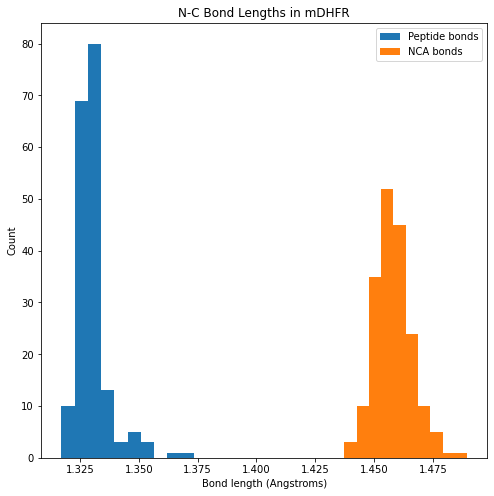

In [8]:
# Plot Histogram of Bond Distances
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(peptide)
ax.hist(alpha)
plt.legend(['Peptide bonds', 'NCA bonds'])
#ax.set_xlim([0, 1.6])

ax.set_title('N-C Bond Lengths in mDHFR')
ax.set_xlabel('Bond length (Angstroms)')
ax.set_ylabel('Count')

plt.savefig('histogram.jpg')
plt.show

# 2. Ligand-binding interactions.

# 2.a Hydrogen Bond identification.

From the coordinates in the structure, calculate how many hydrogen bonds between N and O atoms are formed between mDHFR and MTX, and list the residues (identity and position) in mDHFR & MTX that contribute, along with their distances from each other. Make sure you look for N and O atoms from both molecules! The radii for N & O are 1.5 and 1.6 Å, respectively, so a hydrogen bond will bring them closer together.


# Student Input Cell:


In [9]:
# Find N-O Hydrogen Bonds between MTX and mDHFR
h_bonds = []

for key in aa_res:
    res = aa_res[key]
    for n in res['N']:
        n_coords = n[1]
        for o in mtx_res['O']:
            o_coords = o[1]
            dist = distance.euclidean(n_coords, o_coords)
            if dist < 3.1:
                h_bonds.append((res['name']+str(key+1), n[0], o[0], dist))
    for o in res['O']:
        o_coords = o[1]
        for n in mtx_res['N']:
            n_coords = n[1]
            dist = distance.euclidean(o_coords, n_coords)
            if dist < 3.1:
                h_bonds.append((res['name']+str(key+1), o[0], n[0], dist))
h_bonds

[('ILE7', 'O', 'NA4', 2.542308807373047),
 ('GLU30', 'OE1', 'NA2', 2.7814879417419434),
 ('GLU30', 'OE2', 'N1', 2.8957650661468506),
 ('ASN64', 'ND2', 'O', 2.816410779953003),
 ('LYS68', 'NZ', 'O2', 2.721834659576416),
 ('ARG70', 'NH1', 'O1', 3.011383295059204),
 ('ARG70', 'NH2', 'O2', 2.8708581924438477),
 ('VAL115', 'O', 'NA4', 2.6931955814361572)]

# 3. Analyze bond angles


# 3a. Generate a Ramachandran plot.

To make life easier, I've had you pip install a library that does these calculations for you. Run the code below, and answer the HW questions.

Structure exists: 'PDB/pdb1u70.ent' 
Structure exists: 'PDB/pdb1u70.ent' 


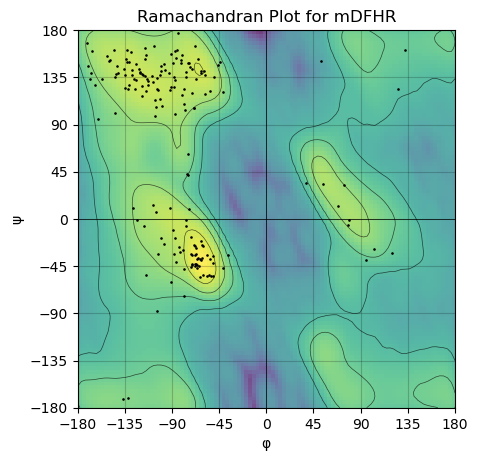

In [10]:
# Drawing the Ramachandran plot
plot(fetch(PDB_id))

# Generating a dictionary to store the phi and psi angles

phi_psi_dict = phi_psi(fetch(PDB_id), return_ignored=False)
plt.title('Ramachandran Plot for mDFHR')

plt.savefig('ramchandran.jpg')
plt.show()

# 3.c Calculate and Plot Omega Angles

For this question, you will need to use the dihedral function I provided up above. You will need to use the right residues in your calculation. Plot the resulting angles you calculate.

# Student Input Cell:


Trans:184  Cis:1


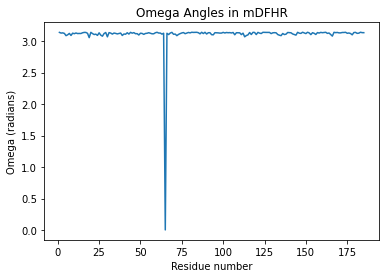

In [11]:
#Calculate & plot omega angles
x = list(range(1, len(aa_res)))
w = []
cis, trans=(0,0)
for i in range(len(aa_res)-1):
    c_alpha = aa_res[i]['C'][0][1]
    c_carboxyl = aa_res[i]['C'][1][1]
    next_n = aa_res[i+1]['N'][0][1]
    next_c_alpha = aa_res[i+1]['C'][0][1]
    omega = abs(dihedral(c_alpha, c_carboxyl, next_n, next_c_alpha))
    w.append(omega)
    if omega > np.pi-.1:
        trans += 1
    elif omega < .1:
        cis += 1
    else:
        assert(False)

print("Trans:" + str(trans) + "  Cis:" + str(cis))
plt.plot(x,w)
plt.title('Omega Angles in mDFHR')
plt.xlabel('Residue number')
plt.ylabel('Omega (radians)')

plt.savefig('omega_values.jpg')
plt.show()